# Upright transform of the reconstructed morhology

This tutorial demonstrates how to perform the upright transform.

Reconstructed morphologies may be oriented in an arbitrary direction in the slice plane. 
For analysis of morphological features it is often necessary to bring reconstruction into a common reference frame with pia facing up. After the transform a tufted dendrite should be largely aligned with the vertical y-axis in the xy coordinates as shown below:

![upright transform before and after](upright_transform_start_end.png "Title")

## Method for finding the upright direction

The upright transform is found by findig the upright direction at the soma location in the slice coordinates and subsequently rotating the reconstruction to align the the upright direction with the vertical axis (y-axis)

The upright direction is found in two steps:
1. Find the isocontours of the cortical depth field.
2. The upright direction is found as a normal to the depth isocontours.

The isocontours are modeled as a solution of the Laplace equation with distinct Direchlet BC on the pia and white matter.
The upright direction at any point in the domain is then modeled as a gradient of the depth field.


In [4]:
import numpy as np
from neuron_morphology.swc_io import morphology_from_swc
import matplotlib.pyplot as plt

from neuron_morphology.transforms.affine_transform import (
    rotation_from_angle, affine_from_transform_translation, affine_from_translation, AffineTransform)

from neuron_morphology.transforms.pia_wm_streamlines.calculate_pia_wm_streamlines import run_streamlines
from neuron_morphology.transforms.upright_angle.compute_angle import get_upright_angle

from neuron_morphology.vis import morphovis as mvis



## Load a reconstruction

In [2]:
# Here we will be loading reconstruction assuming an user has an access to the Allen Institute database 
# Other users would need to provide their own data in the format specified:

from neuron_morphology.lims_apical_queries import get_benchmark_apical
specimens, _ = get_benchmark_apical()

# Choosing a particular cell:
specimen_id = 313862022
specimen = specimens[specimen_id] 

swc_file = specimen["swc_file"] # swc file name
pia_coords = specimen["pia_coords"] # pia coordinates
wm_coords = specimen["wm_coords"] # white matter coordinates
soma_slice = specimen["soma_center"] # soma location





## Find depth field and the upright direction at the soma location

In [5]:
depth_field, gradient_field, translation = run_streamlines(
        specimen["pia_path_str"],
        specimen["wm_path_str"],
        specimen["resolution"],
        specimen["soma_path_str"],
    )
upright_angle = get_upright_angle(gradient_field)

print(f"upright angle (deg) : {upright_angle*180/np.pi}")

upright angle (deg) : 151.5271447243095


## Rotate reconstruction by the upright angle along the z axis

In [10]:
morphology = morphology_from_swc(swc_file) # load Morphology object
soma_morph = morphology.get_soma() # get soma position

# translate morphology to the slice coordinates 
translation_to_slice_coors = np.array([soma_slice[0]-soma_morph['x'], soma_slice[1]-soma_morph["y"], 0])
translation_coeff = affine_from_translation(translation_to_slice_coors)

T_translate = AffineTransform(translation_coeff)
translated_morphology = T_translate.transform_morphology(morphology, clone=True)


# rotate morphology by the upright angle
rotation_coeff = rotation_from_angle(upright_angle, axis=2)
rot_coeff = affine_from_transform_translation(transform=rotation_coeff)

T_rotate = AffineTransform(rot_coeff)
upright_morphology = T_rotate.transform_morphology(morphology, clone=True)

# alternatively, one can combine translation with rotation:

traslate_rotate_coeff = affine_from_transform_translation(
    transform = rotation_coeff,
    translation = translation_coeff,
    translate_first = True)

T_translate_rotate = AffineTransform(traslate_rotate)

upright_morphology = T_translate_rotate.transform_morphology(morphology, clone=True)


## Plot original morphological reconstruction and depth, upright directions

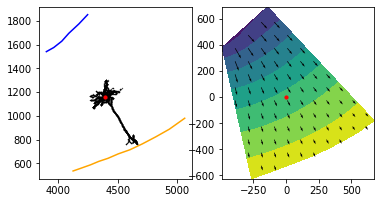

In [13]:

fig, ax = plt.subplots(1, 2)

mvis.plot_morphology_xy(translated_morphology,  ax[0])
mvis.plot_soma(soma_slice,ax[0])
mvis.plot_cortical_boundary(pia_coords, wm_coords,ax[0])

mvis.plot_depth_field(depth_field,ax[1])
mvis.plot_gradient_field(gradient_field,ax[1])
mvis.plot_soma([0,0],ax[1])


## Plot the upright morphology

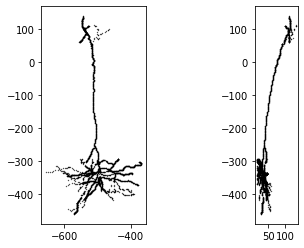

In [11]:
fig, axes = plt.subplots(1, 2)
mvis.plot_morphology_xy(upright_morphology,  axes[0])
mvis.plot_morphology_zy(upright_morphology,  axes[1])
